In [3]:
main_dir = '/Users/simon/bsose_monthly/'
salt = main_dir + 'bsose_i106_2008to2012_monthly_Salt.nc'
theta = main_dir + 'bsose_i106_2008to2012_monthly_Theta.nc'

%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import os, sys
sys.path.insert(0, os.path.abspath('..'))

import pyxpcm
from pyxpcm.models import pcm


def pcm_fit_and_post(time_i=42, K=4, maxvar=2):  
    # Define features to use
    # Instantiate the PCM
    
    max_depth = 2000
    z = np.arange(0., -max_depth, -10.)
    features_pcm = {'THETA': z, 'SALT': z}
    features = {'THETA': 'THETA', 'SALT': 'SALT'}
    salt_nc = xr.open_dataset(salt).isel(time=time_i)
    theta_nc = xr.open_dataset(theta).isel(time=time_i)
    big_nc = xr.merge([salt_nc, theta_nc])
    both_nc = big_nc.where(big_nc.coords['Depth'] > 
                           max_depth).drop(['iter', 'Depth', 
                                            'rA', 'drF', 'hFacC'])   
 
    attr_d = {}

    for coord in both_nc.coords:
        attr_d[coord] = both_nc.coords[coord].attrs
        
    lons_new = np.linspace(both_nc.XC.min(), both_nc.XC.max(), 60*4)
    lats_new = np.linspace(both_nc.YC.min(), both_nc.YC.max(), 60)
    # ds = both_nc # .copy(deep=True)
    ds = both_nc.interp(coords={'YC': lats_new, 'XC': lons_new})#, method='cubic')
        
    m = pcm(K=K, features=features_pcm, 
            maxvar=maxvar, 
            #timeit=True, timeit_verb=1, 
            separate_pca=False)
    m.fit(ds, features=features, dim='Z') #, inplace=True)
    m.predict(ds, features=features, dim='Z', inplace=True)
    m.predict_proba(ds, features=features, dim='Z', inplace=True)
    m.find_i_metric(ds, inplace=True)
    
    def sanitize():
        del ds.PCM_LABELS.attrs['_pyXpcm_cleanable']
        del ds.PCM_POST.attrs['_pyXpcm_cleanable']
        del ds.PCM_RANK.attrs['_pyXpcm_cleanable']
        
    for coord in attr_d:
        ds.coords[coord].attrs = attr_d[coord]
    
    sanitize()
    return ds, m

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
ds, m = pcm_fit_and_post(time_i=42, K=4, maxvar=2)

Fitting PCA
[(0, 0), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (3, 3)]
(10437, 2)
(10437, 4)


In [31]:
shape = np.shape(ds.PCM_POST.values)
ic_metric = np.zeros([shape[1], shape[2]])
a_b = np.zeros([2, shape[1], shape[2]])

for i in range(shape[1]):
    for j in range(shape[2]):
        ic_metric[i, j], a_b[:, i, j] = get_i_metric(ds.PCM_POST.values[:, i, j].tolist())

In [26]:
def get_i_metric(posterior_prob_list):
    """
    :return: gmm_profile list:
    :return: gmm: the gmm object to save.
    """
    if np.nan not in posterior_prob_list:

        sorted_posterior_list = sorted(posterior_prob_list)

        ic_metric = 1 - (sorted_posterior_list[-1] - sorted_posterior_list[-2])

        runner_up_label = posterior_prob_list.index(sorted_posterior_list[-2])

        label = posterior_prob_list.index(sorted_posterior_list[-1])

        return ic_metric, np.array([label, runner_up_label])
    
    else:
        
        return np.nan, np.array([np.nan, np.nan])


In [29]:
shape

(4, 60, 240)

In [32]:
ic_metric

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., nan, ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [33]:
np.shape(ic_metric)

(60, 240)

In [34]:
a_b

array([[[3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 3., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.],
        ...,
        [2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.]]])

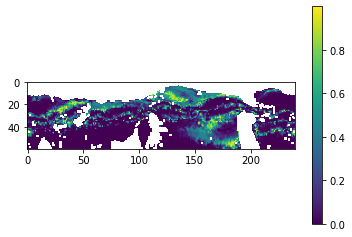

In [37]:
plt.imshow(ic_metric)
plt.colorbar()

In [41]:
ds = m.find_i_metric(ds, features=None, dim=None, inplace=True,
                     name='PCM_I', classdimname='pcm_class')


[(0, 0), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (3, 3)]
(10437, 2)


/Users/simon/pyxpcm/pyxpcm/xarray.py:93: UserWarning: I_METRIC variable already in the dataset: overwriting
  warnings.warn(("%s variable already in the dataset: overwriting") % (da.name))


In [42]:
ds

<xarray.Dataset>
Dimensions:     (XC: 240, YC: 60, Z: 52, i-metric: 1, pcm_class: 4, rank: 2)
Coordinates:
    time        datetime64[ns] 2011-08-01T15:12:00
  * Z           (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * YC          (YC) float64 -77.98 -77.16 -76.35 ... -31.35 -30.53 -29.72
  * XC          (XC) float64 0.08333 1.589 3.094 4.6 ... 355.4 356.9 358.4 359.9
Dimensions without coordinates: i-metric, pcm_class, rank
Data variables:
    SALT        (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    THETA       (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    PCM_LABELS  (YC, XC) float64 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    PCM_POST    (pcm_class, YC, XC) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
    PCM_RANK    (pcm_class, YC, XC) float64 nan nan nan nan ... 3.0 3.0 3.0 3.0
    I_METRIC    (i-metric, YC, XC) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
    A_B         (rank, YC, XC) float64 nan nan nan nan nan ... 2.0 2.0 2.0 2.0

In [43]:
ds.I_METRIC

<xarray.DataArray 'I_METRIC' (i-metric: 1, YC: 60, XC: 240)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0., nan, ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])
Coordinates:
    time     datetime64[ns] 2011-08-01T15:12:00
  * YC       (YC) float64 -77.98 -77.16 -76.35 -75.53 ... -31.35 -30.53 -29.72
  * XC       (XC) float64 0.08333 1.589 3.094 4.6 ... 355.4 356.9 358.4 359.9
Dimensions without coordinates: i-metric
Attributes:
    long_name:          I metric
    units:              
    valid_min:          0
    valid_max:          1
    _pyXpcm_cleanable:  True

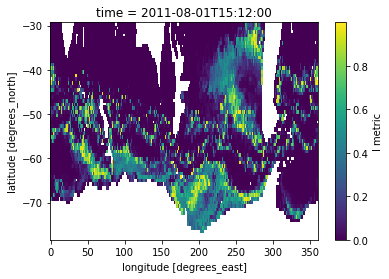

In [44]:
ds.I_METRIC.plot()

In [45]:
import sithom_plot_style as sps

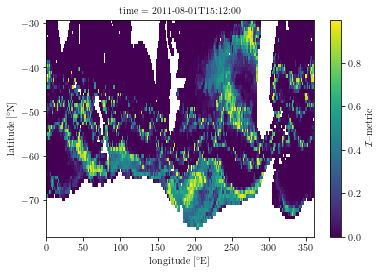

In [52]:
sps.ds_for_graphing(ds.drop(['SALT', 'THETA'])).I_METRIC.plot()

In [49]:
ds

<xarray.Dataset>
Dimensions:     (XC: 240, YC: 60, Z: 52, i-metric: 1, pcm_class: 4, rank: 2)
Coordinates:
    time        datetime64[ns] 2011-08-01T15:12:00
  * Z           (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * YC          (YC) float64 -77.98 -77.16 -76.35 ... -31.35 -30.53 -29.72
  * XC          (XC) float64 0.08333 1.589 3.094 4.6 ... 355.4 356.9 358.4 359.9
Dimensions without coordinates: i-metric, pcm_class, rank
Data variables:
    SALT        (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    THETA       (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    PCM_LABELS  (YC, XC) float64 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    PCM_POST    (pcm_class, YC, XC) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
    PCM_RANK    (pcm_class, YC, XC) float64 nan nan nan nan ... 3.0 3.0 3.0 3.0
    I_METRIC    (i-metric, YC, XC) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
    A_B         (rank, YC, XC) float64 nan nan nan nan nan ... 2.0 2.0 2.0 2.0